### **Environment Setup: Install and import required package**
---

* Set directory to Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication

In [ ]:
# Install the package
!pip install -e .

In [ ]:
from models.feature_extractor import ResNetFeatureExtractor
from utils.helpers import load_config,get_model_from_Kaggle, load_model
from utils.model_evaluation import evaluate_model, draw_plot_evaluate, draw_plot_find_acc
from models.Triplet_Siamese_Similarity_Network import tSSN
from losses.triplet_loss import TripletLoss
from dataloader.tSSN_trainloader import SignatureTrainDataset
from dataloader.tSSN_testloader import SignatureTestDataset

In [ ]:
import os
import sys
import time
import gc
import random
import psutil
import shutil
import kagglehub
import itertools

import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, confusion_matrix, precision_recall_curve
)

# Set global seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## **Dataset Processing**

In [ ]:
dataset = kagglehub.dataset_download("shreelakshmigp/cedardataset")
print("Path to dataset files [shreelakshmigp]:", dataset)
sys.path.append(dataset)

In [7]:
# Transform chung
transform = transforms.Compose([
    transforms.Resize((220, 150)),
    transforms.Grayscale(),  # Đảm bảo ảnh 1 kênh xám
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # 1 kênh -> 3 kênh
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = SignatureTrainDataset(
    org_dir = dataset + '/signatures/full_org',
    forg_dir = dataset + '/signatures/full_forg',
    transform=transform
)

train_size = int(0.8 * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, len(dataset) - train_size]
)

train_loader = DataLoader(train_dataset, num_workers=0, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, num_workers=0, batch_size=32, shuffle=False)

In [8]:
# Kiểm tra Triplet Dataset
print(f"Dataset - Total triplets: {len(dataset)}")

anchor, positive, negative = dataset[0]

print(f"Anchor shape: {anchor.shape}")
print(f"Positive shape: {positive.shape}")
print(f"Negative shape: {negative.shape}")

print(f"Training dataset: {len(train_dataset)}")

anchor_train, positive_train, negative_train = train_dataset[0]

print(f"Anchor shape: {anchor_train.shape}")
print(f"Positive shape: {positive_train.shape}")
print(f"Negative shape: {negative_train.shape}")

print(f"Testing dataset: {len(test_dataset)}")

anchor_test, positive_test, negative_test = test_dataset[0]

print(f"Anchor shape: {anchor_test.shape}")
print(f"Positive shape: {positive_test.shape}")
print(f"Negative shape: {negative_test.shape}")

print("LOAD DATASET SUCCESSFULLY")
print(f"Train-Test Split Ratio: {len(train_dataset)/len(dataset)*100:.1f}% - {len(test_dataset)/len(dataset)*100:.1f}%")

Dataset - Total triplets: 1320
Anchor shape: torch.Size([3, 220, 150])
Positive shape: torch.Size([3, 220, 150])
Negative shape: torch.Size([3, 220, 150])
Training dataset: 1056
Anchor shape: torch.Size([3, 220, 150])
Positive shape: torch.Size([3, 220, 150])
Negative shape: torch.Size([3, 220, 150])
Testing dataset: 264
Anchor shape: torch.Size([3, 220, 150])
Positive shape: torch.Size([3, 220, 150])
Negative shape: torch.Size([3, 220, 150])
LOAD DATASET SUCCESSFULLY
Train-Test Split Ratio: 80.0% - 20.0%


## **Load Model**


In [9]:
config = load_config('configs/config_tSSN.yaml')
print(config)
print("LOAD CONFIG SUCCESSFULLY")

{'model': {'name': 'tSSN', 'backbone': 'resnet34', 'feature_dim': 512, 'kaggle_handle': 'giahuytranviet/tSSN-verification-model/pyTorch/default/3'}, 'training': {'batch_size': 32, 'learning_rate': 0.001, 'early_stop': 3, 'optimizer': 'adam', 'num_epochs': 100, 'margin': 0.5, 'scheduler': 'cosine'}, 'dataset': {'train_data_path': './data/triplet/train/', 'val_data_path': './data/triplet/val/', 'input_size': '(220,150)'}, 'device': 'cuda', 'logging': {'log_dir': './logs/', 'checkpoint_dir': './checkpoints/', 'save_freq': 5}}
LOAD CONFIG SUCCESSFULLY


In [ ]:
get_model_from_Kaggle(config['model']['kaggle_handle'])

- **How to Set `model_path` After Downloading from KaggleHub**
  - After downloading a model using `kagglehub`, the file is typically saved in the following directory:
    ```
    C:\Users\<YOUR_USERNAME>\.cache\kagglehub\models\<author>\<model-name>\pyTorch\default\<version>\
    ```
  - To locate and use your model:
    - Open the folder path shown in the terminal output after downloading.
    - Look for the model file (e.g., `your_model_file.pth` or something like `model_xyz`).
    - Copy the full file name.
    - Complete your model path in Python like this:
      ```python
      model_path = r'C:\Users\USER\.cache\kagglehub\models\<author>\<model-name>\pyTorch\default\<version>\<your_model_file>'
      ```
    - **Example:**
      ```python
      model_path = r'C:\Users\USER\.cache\kagglehub\models\giahuytranviet\tSSN-verification-model\pyTorch\default\3\tSNN_euclidean_0.6.pth'
      ```

In [ ]:
#Set model path
model_path = r'C:\Users\USER\.cache\kagglehub\models\giahuytranviet\tSSN-verification-model\pyTorch\default\3\tSNN_euclidean_0.6'

In [ ]:
model = load_model(model_path, config['model']['backbone'], config['model']['feature_dim'])

In [ ]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() and config['device']=='cuda' else 'cpu')
print(f"Using device: {device}")

In [ ]:
model = torch.nn.DataParallel(model, device_ids=[0])
model.to(device)

## **Model Evaluation: Metrics Visualization**


In [15]:
# Memory tracking class
class MemoryTracker:
    def __init__(self):
        self.proc = psutil.Process(os.getpid())
        self.start = self.peak = self.end = None

    def start_tracking(self):
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        self.start = self.proc.memory_info().rss / 1e6
        self.peak = self.start

    def update(self):
        cur = self.proc.memory_info().rss / 1e6
        self.peak = max(self.peak, cur)

    def end_tracking(self):
        self.end = self.proc.memory_info().rss / 1e6

    def summary(self):
        return {
            'start_MB': self.start,
            'peak_MB': self.peak,
            'end_MB': self.end,
            'delta_MB': self.end - self.start
        }

In [16]:
tracker = MemoryTracker()
tracker.start_tracking()
t0 = time.time()

result = evaluate_model(model, 'euclidean', test_loader, device)

tracker.end_tracking()
exec_time = time.time() - t0
mem_stats = tracker.summary()
print(f"Execution time: {exec_time:.2f}s")
print("Memory usage (MB):", mem_stats)

Evaluating with euclidean: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]

Execution time: 7.59s
Memory usage (MB): {'start_MB': 3739.344896, 'peak_MB': 3739.344896, 'end_MB': 5609.631744, 'delta_MB': 1870.2868480000002}



Results Table:
   accuracy  precision    recall        f1   roc_auc  threshold       far       frr       eer  eer_threshold
0  0.956439   0.968872  0.943182  0.955854  0.989827   5.008144  0.030303  0.056818  0.051136       5.405755


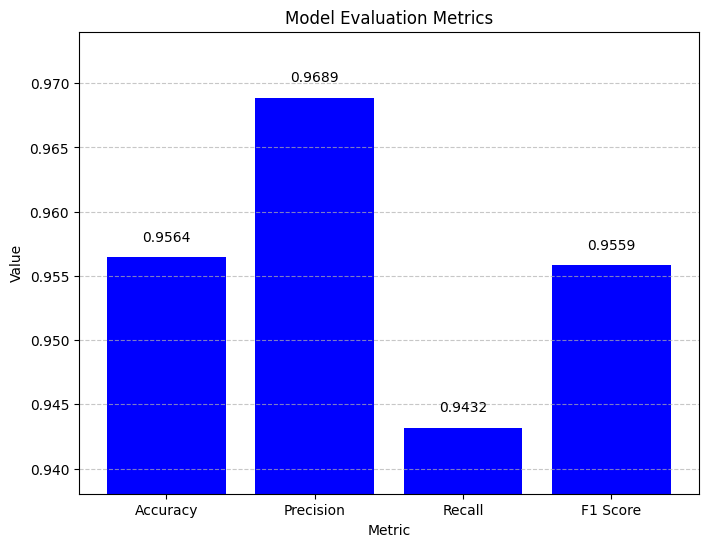

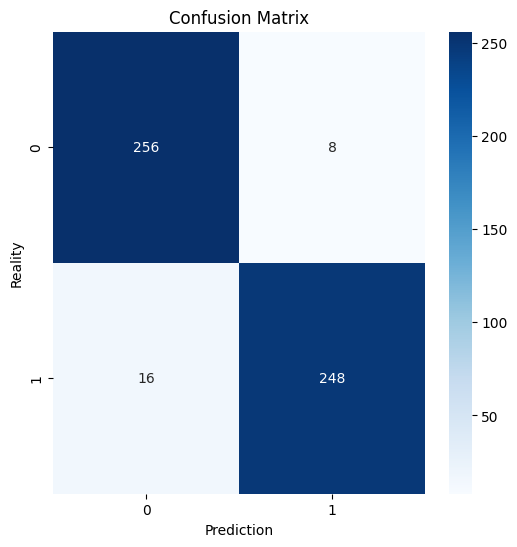

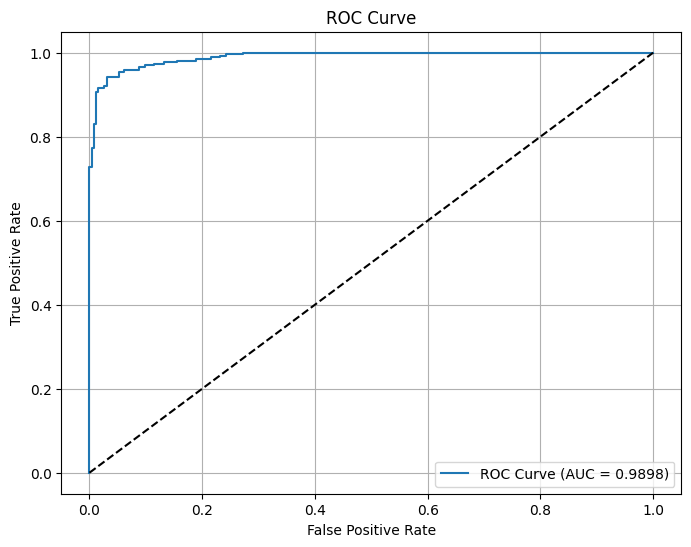

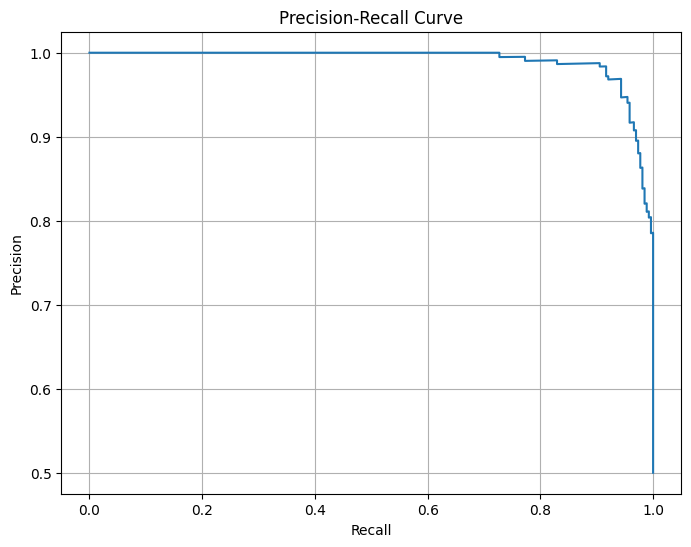

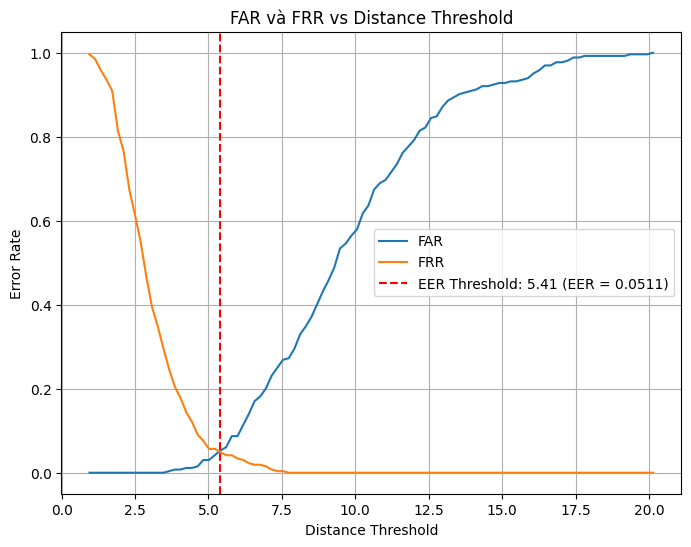

In [ ]:
# Metrics Visualization (Confusion Matrix, Accuracy, ROC, FRR, FAR)
draw_plot_evaluate(result, "all")